##### * Phishing website detection using machine learning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### * Library importing

In [3]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix

import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics 
import matplotlib.pyplot as plt # It provides an object-oriented API for embedding plots into applications
%matplotlib inline 
# It sets the backend of matplotlib to the 'inline' backend:
import time # calculate time 

from sklearn.linear_model import LogisticRegression # algo use to predict good or bad
from sklearn.naive_bayes import MultinomialNB # nlp algo use to predict good or bad

from sklearn.model_selection import train_test_split # spliting the data between feature and target
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text  
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer # create sparse matrix of words using regexptokenizes  
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos

from PIL import Image # getting images in notebook
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud

from bs4 import BeautifulSoup # use for scraping the data from website
import networkx as nx # for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

import pickle# use to dump model 

import warnings # ignores pink warnings 
warnings.filterwarnings('ignore')

* **Loading the  dataset.**

In [4]:
phish_data = pd.read_csv('/content/drive/MyDrive/Main Project/phishing_site_urls.csv')

In [5]:
phish_data.head(10)

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
5,smilesvoegol.servebbs.org/voegol.php,bad
6,premierpaymentprocessing.com/includes/boleto-2...,bad
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad
8,super1000.info/docs,bad
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad


In [6]:
phish_data.tail()

,URL,Label
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad
549346,http://shabyhumne.top/omannairosyw/tb.php?piao...,bad


In [7]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549347 entries, 0 to 549346
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549347 non-null  object
 1   Label   549347 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


* **Checking classes are balanced or inbalanced**

In [8]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(phish_data.Label.value_counts())

In [9]:
print(label_counts)

       Label
good  392924
bad   156423


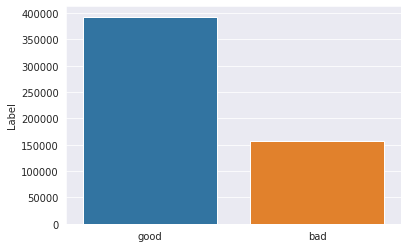

In [10]:
#visualizing target_col
sns.set_style('darkgrid')
sns.barplot(label_counts.index,label_counts.Label)

### Preprocessing

* **Now that we have the data, we have to vectorize our URLs. I used CountVectorizer and gather words using tokenizer, since there are words in urls that are more important than other words e.g ‘virus’, ‘.exe’ ,’.dat’ etc. Lets convert the URLs into a vector form.**

#### RegexpTokenizer
* A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.

In [11]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [12]:
phish_data.URL[1]

'www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php'

In [13]:
1# this will be pull letter which matches to expression
tokenizer.tokenize(phish_data.URL[1]) # using first row

['www',
 'dghjdgf',
 'com',
 'paypal',
 'co',
 'uk',
 'cycgi',
 'bin',
 'webscrcmd',
 'home',
 'customer',
 'nav',
 'loading',
 'php']

In [14]:
# tokenizing
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows


In [15]:
phish_data.tail(5)

,URL,Label,text_tokenized
549342,apple-checker.org/,bad,"[apple, checker, org]"
549343,apple-iclods.org/,bad,"[apple, iclods, org]"
549344,apple-uptoday.org/,bad,"[apple, uptoday, org]"
549345,apple-search.info,bad,"[apple, search, info]"
549346,http://shabyhumne.top/omannairosyw/tb.php?piao...,bad,"[http, shabyhumne, top, omannairosyw, tb, php,..."


In [16]:
stemmer = SnowballStemmer("english") # choose a language

In [17]:
# stemming
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l]) #affect all rows


In [18]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed
322197,enotes.com/evans-connell-jr-salem/evan-s-conne...,good,"[enotes, com, evans, connell, jr, salem, evan,...","[enot, com, evan, connel, jr, salem, evan, s, ..."
74371,www.cambridge.org/uk/catalogue/catalogue.asp?i...,good,"[www, cambridge, org, uk, catalogue, catalogue...","[www, cambridg, org, uk, catalogu, catalogu, a..."
407952,nytimes.com/2008/02/22/world/americas/22iht-yo...,good,"[nytimes, com, world, americas, iht, yogi, html]","[nytim, com, world, america, iht, yogi, html]"
277135,amazon.com/Simple-Steps-Green-Meetings-Events/...,good,"[amazon, com, Simple, Steps, Green, Meetings, ...","[amazon, com, simpl, step, green, meet, event,..."
159732,collegefootball.about.com/od/coachinggreats/a/...,good,"[collegefootball, about, com, od, coachinggrea...","[collegefootbal, about, com, od, coachinggreat..."


In [19]:
# joining
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))


In [20]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
482674,foursquare.com/v/bolles-george-h--hodges-field...,good,"[foursquare, com, v, bolles, george, h, hodges...","[foursquar, com, v, boll, georg, h, hodg, fiel...",foursquar com v boll georg h hodg field bc e e...
4553,www.legacysz.com/images/?,bad,"[www, legacysz, com, images]","[www, legacysz, com, imag]",www legacysz com imag
320013,ehow.com/facts_6952538_2004-pontiac-gto-specs....,good,"[ehow, com, facts, pontiac, gto, specs, html]","[ehow, com, fact, pontiac, gto, spec, html]",ehow com fact pontiac gto spec html
386791,mediafire.com/?zlc0swm1j0y,good,"[mediafire, com, zlc, swm, j, y]","[mediafir, com, zlc, swm, j, y]",mediafir com zlc swm j y
117030,cclpgms.com/js/?https:/us.battle.net/login/,bad,"[cclpgms, com, js, https, us, battle, net, login]","[cclpgms, com, js, https, us, battl, net, login]",cclpgms com js https us battl net login


### Visualization 


In [21]:
#sliceing classes
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [22]:
good_sites.head(10)

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira��&nvinip��ncH��wV��%����yDaH����/��yE...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,www.institutocgr.coo/web/media/syqvem/dk-��ij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Y������ ko����������D����l����������qt����/...,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...
18237,��5092,good,[],[],
18238,esxcc.com/js/index.htm?us.battle.net/login/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, l...",esxcc com js index htm us battl net login en r...
18239,esxcc.com/js/index.htm?us.battle.net/login/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, l...",esxcc com js index htm us battl net login en r...
18240,@ ������ \ t���������� ��,good,[t],[t],t
18241,>Iq9E)��l��0��Z������w!'��p����W��&���� p...,good,"[Iq, E, l, Z, w, p, W, p, Im, Y]","[iq, e, l, z, w, p, w, p, im, y]",iq e l z w p w p im y


In [23]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira��&nvinip��ncH��wV��%����yDaH����/��yE...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,www.institutocgr.coo/web/media/syqvem/dk-��ij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Y������ ko����������D����l����������qt����/...,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


* create a function to visualize the important keys from url 

### Creating Model

#### CountVectorizer
* CountVectorizer is used to transform a corpora of text to a vector of term / token counts.

In [24]:
#create cv object
cv = CountVectorizer()

In [25]:
feature = cv.fit_transform(phish_data.text_sent) #transform all text which we tokenize and stemed

In [26]:
feature.shape

(549347, 350840)

In [27]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### * Spliting the data 

In [28]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

### LogisticRegression
* Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [29]:
# create lr object
lr = LogisticRegression()

In [30]:
lr.fit(trainX,trainY) #training

LogisticRegression()

In [31]:
lr.score(testX,testY) #testing

0.9625374079818257

.*** Logistic Regression is giving 96% accuracy, Now we will store scores in dict to see which model perform best**

In [32]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9765612485133855
Testing Accuracy : 0.9625374079818257

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.90      0.97      0.93     36555
        Good       0.99      0.96      0.97    100782

    accuracy                           0.96    137337
   macro avg       0.94      0.96      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


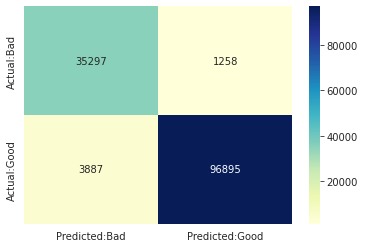

In [33]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### MultinomialNB
* Applying Multinomial Naive Bayes to NLP Problems. Naive Bayes Classifier Algorithm is a family of probabilistic algorithms based on applying Bayes' theorem with the “naive” assumption of conditional independence between every pair of a feature.

In [34]:
# create mnb object
mnb = MultinomialNB()

In [35]:
mnb.fit(trainX,trainY)

MultinomialNB()

In [36]:
mnb.score(testX,testY)

0.9570399819422297

*** MultinomialNB gives us 95% accuracy**  

In [37]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9738744205237737
Testing Accuracy : 0.9570399819422297

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.94      0.92     38224
        Good       0.97      0.97      0.97     99113

    accuracy                           0.96    137337
   macro avg       0.94      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


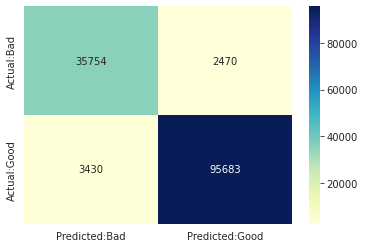

In [38]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

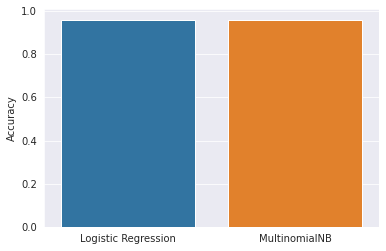

In [39]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index,acc.Accuracy)

*** So, Logistic Regression is the best fit model, Now we make sklearn pipeline using Logistic Regression**

In [40]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())
##(r'\b(?:http|ftp)s?://\S*\w|\w+|[^\w\s]+') ([a-zA-Z]+)([0-9]+) -- these tolenizers giving me low accuray 

In [41]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [42]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('logisticregression', LogisticRegression())])

In [43]:
pipeline_ls.score(testX,testY) 

0.9665057486329248

Training Accuracy : 0.9809276473871993
Testing Accuracy : 0.9665057486329248

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     37022
        Good       0.99      0.97      0.98    100315

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


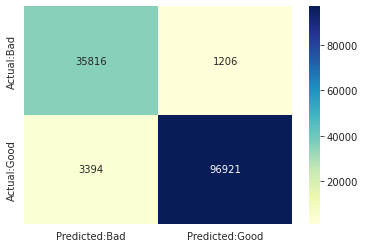

In [44]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [45]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [46]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9665057486329248
